In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Agent training

In [30]:
import numpy as np
import random as rd
from transformers import AutoImageProcessor
import torch
from torch.utils.data import DataLoader
from stable_baselines3 import PPO
from stable_baselines3.common import env_checker


from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.modeling.img_env.img_exploration_env import RewardFunction, ImageExplorationEnv, ImageExplorationEnvConfig
from uav_active_sensing.modeling.mae.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.plots import visualize_tensor
from uav_active_sensing.modeling.agents.rl_agent_feature_extractor import CustomResNetFeatureExtractor
from uav_active_sensing.config import SEED, DEVICE

In [31]:

training_generator = torch.Generator(device=DEVICE).manual_seed(SEED)


image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
tiny_imagenet_train_dataset = TinyImageNetDataset(split="train", transform=image_processor)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn, generator=training_generator, shuffle=True)

# Pretrained model and reward function
mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
reward_function = RewardFunction(mae_model)

# Create a dummy environment to initialize the model
dummy_batch = next(iter(tiny_imagenet_train_loader))  # Take one image as a dummy input for env initialization
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)

In [32]:
env_checker.check_env(env)

/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


### Test loader deterministic behaviour

In [33]:
image_processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [50]:
# Use in case of multi processing data loading
def worker_init_fn(worker_id): 
    worker_seed = SEED + worker_id
    torch.cuda.manual_seed_all(worker_seed)
    np.random.seed(worker_seed)
    rd.seed(worker_seed)


In [51]:
training_generator = torch.Generator(device=DEVICE).manual_seed(SEED)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn, generator=training_generator, shuffle=True)

first_run_batches = []
for i, batch in enumerate(tiny_imagenet_train_loader):
  first_run_batches.append(batch)

  if i == 5:
    break

training_generator = torch.Generator(device=DEVICE).manual_seed(SEED)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn, generator=training_generator, shuffle=True)


second_run_batches = []
for i, batch in enumerate(tiny_imagenet_train_loader):
  second_run_batches.append(batch)

  if i == 5:
    break

for i in range(5):
  print(torch.equal(first_run_batches[i], second_run_batches[i]))


True
True
True
True
True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.4285712].


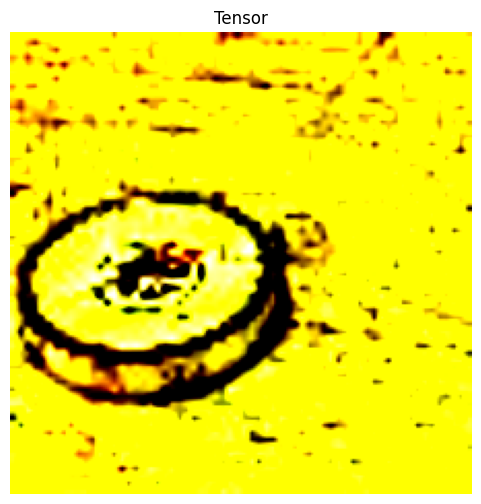

In [52]:
visualize_tensor(first_run_batches[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.4285712].


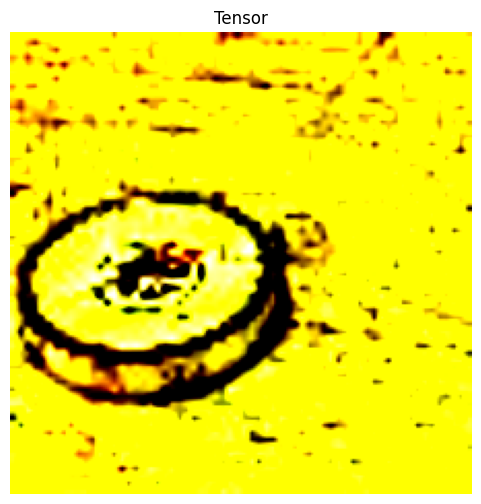

In [53]:
visualize_tensor(second_run_batches[0][0])

### Batch env

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.4285712].


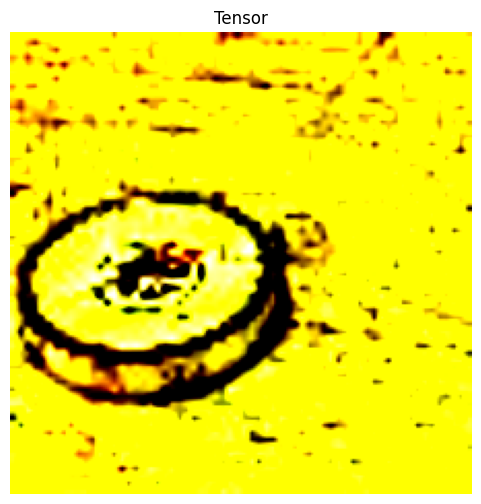

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.4285712].


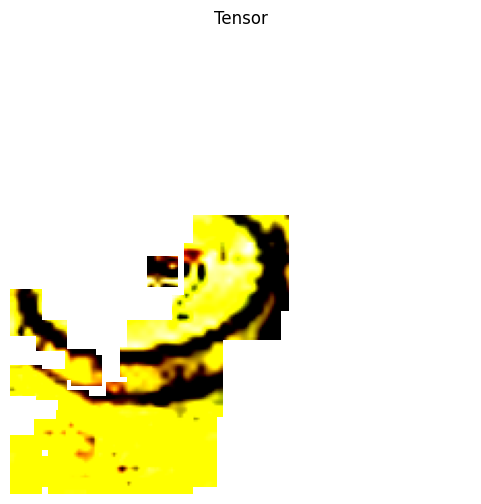

In [54]:
for _ in range(env.max_steps):
    sample_action = env.action_space.sample()
    env.step(sample_action)

for i in range(env.batch_size):
    visualize_tensor(env.img[i])
    visualize_tensor(env.sampled_img[i])

### Agent training

In [55]:
rl_num_envs = 1
rl_batch_size = 4
rl_num_steps = rl_batch_size * rl_num_envs * 4

policy_kwargs = dict(
    features_extractor_class=CustomResNetFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=512),
)
env.reset()
resnet_rl_model = PPO(
    "CnnPolicy",
    env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    n_steps=rl_num_steps,
    batch_size=rl_batch_size,
    seed=SEED
)

for i, batch in enumerate(tiny_imagenet_train_loader):
    vec_env = resnet_rl_model.get_env()
    vec_env.env_method("set_img", batch)
    resnet_rl_model.learn(total_timesteps=4 * rl_num_steps, progress_bar=False)

    if i == 1:
        break

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 3  |
|    iterations      | 1  |
|    time_elapsed    | 4  |
|    total_timesteps | 16 |
---------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31          |
|    ep_rew_mean          | 3.18        |
| time/                   |             |
|    fps                  | 1           |
|    iterations           | 2           |
|    time_elapsed         | 21          |
|    total_timesteps      | 32          |
| train/                  |             |
|    approx_kl            | 0.016293671 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | -0.00875    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0366    

In [56]:
# test_env = ImageExplorationEnv(env_config)
test_env = resnet_rl_model.env.envs[0].env


# Reset environment and get initial observation
obs, _ = test_env.reset()

# Number of steps to run the evaluation
num_eval_steps = 30

# Disable training mode
resnet_rl_model.policy.eval()

for step in range(num_eval_steps):

    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    action, _ = resnet_rl_model.predict(obs_tensor, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)

    # Print results
    print(f"Step {step + 1}: Action={action}, Reward={reward}")

    # if terminated or truncated:
    #     print("Episode ended, resetting environment.")
    #     obs, _ = test_env.reset()

Step 1: Action=[[0.25066763 0.09761492 0.06769978]], Reward=0.2979843020439148
Step 2: Action=[[0.25061688 0.09760089 0.06761212]], Reward=0.0
Step 3: Action=[[0.25064707 0.09763708 0.06733337]], Reward=0.0
Step 4: Action=[[0.25054678 0.09788973 0.06658829]], Reward=0.0
Step 5: Action=[[0.25036773 0.09807985 0.06599536]], Reward=0.0
Step 6: Action=[[0.25052583 0.09839278 0.06230446]], Reward=0.2979843020439148
Step 7: Action=[[0.25030243 0.09969582 0.0562759 ]], Reward=0.0
Step 8: Action=[[0.2507754  0.1000805  0.05311563]], Reward=0.0
Step 9: Action=[[0.25055313 0.10162186 0.04588818]], Reward=0.0
Step 10: Action=[[0.25044537 0.10291348 0.03596191]], Reward=0.0
Step 11: Action=[[0.2509982  0.10291779 0.03795527]], Reward=0.31908831000328064
Step 12: Action=[[0.24994706 0.10466443 0.03138972]], Reward=0.0
Step 13: Action=[[0.24960715 0.1048597  0.03115872]], Reward=0.0
Step 14: Action=[[0.25013405 0.10465118 0.03275647]], Reward=0.0
Step 15: Action=[[0.25022733 0.10482688 0.03175972]],

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9809059..2.64].


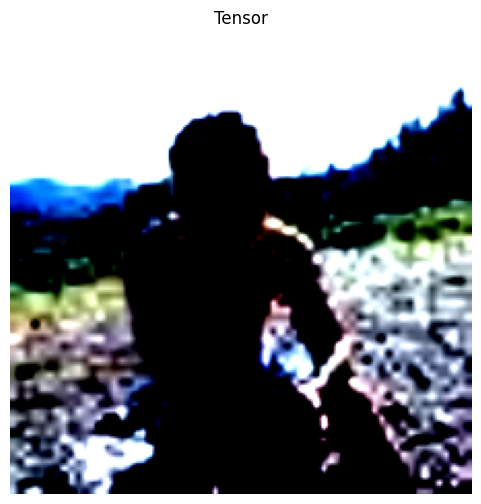

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.415789..1.9079739].


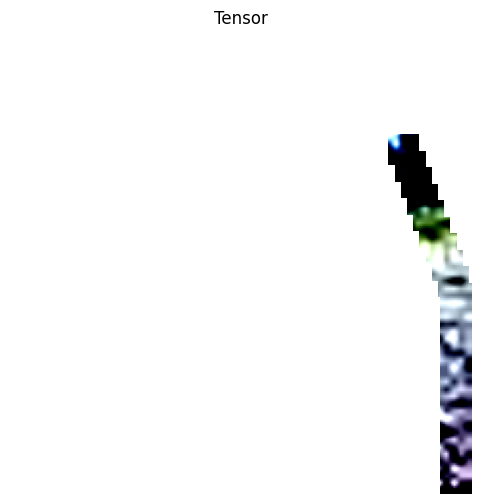

In [57]:
for i in range(test_env.batch_size):
    visualize_tensor(test_env.img[i])
    visualize_tensor(test_env.sampled_img[i])

In [58]:
# test_env = ImageExplorationEnv(env_config)
test_env = resnet_rl_model.env.envs[0].env


# Reset environment and get initial observation
obs, _ = test_env.reset()

# Number of steps to run the evaluation
num_eval_steps = 30

# Disable training mode
resnet_rl_model.policy.eval()

for step in range(num_eval_steps):

    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    action, _ = resnet_rl_model.predict(obs_tensor, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)

    # Print results
    print(f"Step {step + 1}: Action={action}, Reward={reward}")

    # if terminated or truncated:
    #     print("Episode ended, resetting environment.")
    #     obs, _ = test_env.reset()

Step 1: Action=[[ 0.26372224  0.14118819 -0.29126325]], Reward=0.2979843020439148
Step 2: Action=[[ 0.25889623  0.13772006 -0.28959742]], Reward=0.0
Step 3: Action=[[ 0.24997099  0.13490982 -0.27809212]], Reward=0.0
Step 4: Action=[[ 0.25021774  0.13539298 -0.2788627 ]], Reward=0.0
Step 5: Action=[[ 0.25766277  0.13614865 -0.28947634]], Reward=0.0
Step 6: Action=[[ 0.25647566  0.13782388 -0.28506824]], Reward=0.2979843020439148
Step 7: Action=[[ 0.2589882   0.13880621 -0.28767297]], Reward=0.0
Step 8: Action=[[ 0.25524887  0.1358288  -0.2860176 ]], Reward=0.0
Step 9: Action=[[ 0.25017732  0.13545239 -0.27806637]], Reward=0.0
Step 10: Action=[[ 0.24945335  0.13422123 -0.27867374]], Reward=0.0
Step 11: Action=[[ 0.25184435  0.1364938  -0.27906403]], Reward=0.2979843020439148
Step 12: Action=[[ 0.2520235   0.13686676 -0.2787859 ]], Reward=0.0
Step 13: Action=[[ 0.25295657  0.13776691 -0.27900913]], Reward=0.0
Step 14: Action=[[ 0.25244418  0.13691972 -0.2796649 ]], Reward=0.0
Step 15: Act

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9809059..2.64].


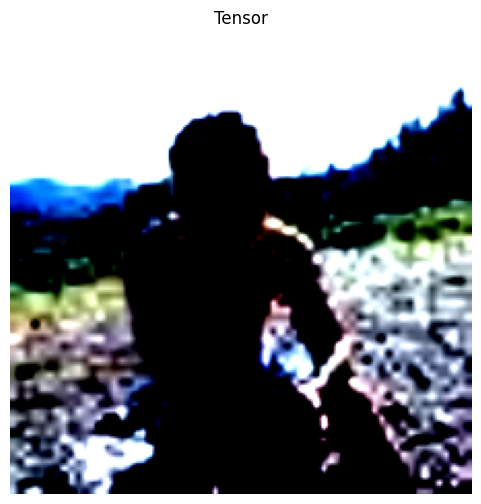

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3179271..2.64].


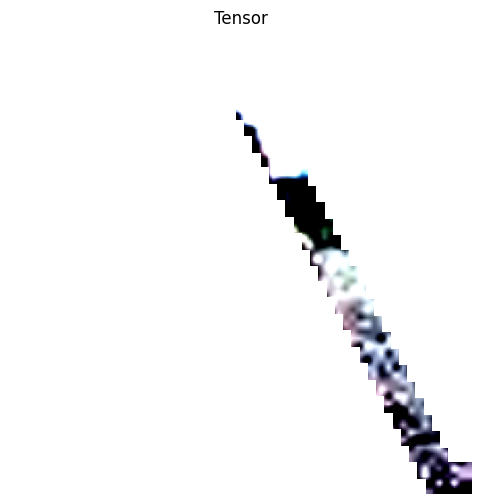

In [59]:
for i in range(test_env.batch_size):
    visualize_tensor(test_env.img[i])
    visualize_tensor(test_env.sampled_img[i])